In [31]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from rclpy.serialization import deserialize_message
from rosidl_runtime_py.utilities import get_message
from scipy.signal import find_peaks

In [32]:
def get_topic_data(cursor, topic_name, msg_type):
    cursor.execute(f"SELECT timestamp, data FROM messages WHERE topic_id = (SELECT id FROM topics WHERE name = '{topic_name}')")
    
    timestamps = []
    data_values = []

    msg_class = get_message(msg_type)
    
    for row in cursor.fetchall():
        timestamp = row[0] / 1e9  # 나노초를 초로 변환
        serialized_data = row[1]
        msg = deserialize_message(serialized_data, msg_class)
        timestamps.append(timestamp)
        data_values.append(msg.data / 1000.0)  # 값을 1000으로 나눔
    
    return np.array(timestamps), np.array(data_values)

In [33]:
def process_data(db_path):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # /sp 토픽 데이터 가져오기
    sp_timestamps, sp_values = get_topic_data(cursor, '/sp', 'std_msgs/msg/Int32')

    # 피크 탐지
    peaks, _ = find_peaks(sp_values)

    if len(peaks) > 1:
        # 모든 사이클의 길이를 동일하게 맞추기 위해 가장 짧은 사이클의 길이 계산
        min_length = min(peaks[i+1] - peaks[i] for i in range(len(peaks) - 1))
        
        # 모든 사이클 데이터를 수집
        sp_cycles = []
        force_cycles = []
        
        for i in range(len(peaks) - 1):
            # 각 사이클에 대한 sp 데이터 추출 및 길이 조정
            start_index = peaks[i]
            end_index = start_index + min_length
            
            sp_values_cycle = sp_values[start_index:end_index]
            sp_cycles.append(sp_values_cycle)
            
            # /force 토픽 데이터 가져오기
            force_timestamps, force_values = get_topic_data(cursor, '/force', 'std_msgs/msg/Int32')
            
            # 동일한 타임스탬프 기준으로 force 데이터 추출
            mask_cycle = (force_timestamps >= sp_timestamps[start_index]) & (force_timestamps <= sp_timestamps[end_index])
            force_values_cycle = force_values[mask_cycle]
            
            # force 데이터도 길이를 동일하게 맞추기
            if len(force_values_cycle) > min_length:
                force_values_cycle = force_values_cycle[:min_length]
            elif len(force_values_cycle) < min_length:
                force_values_cycle = np.pad(force_values_cycle, (0, min_length - len(force_values_cycle)), 'edge')
            
            force_cycles.append(force_values_cycle)
        
        # 모든 사이클의 데이터를 평균 및 표준편차 계산
        mean_sp_values = np.mean(np.array(sp_cycles), axis=0)
        mean_force_values = np.mean(np.array(force_cycles), axis=0)
        std_force_values = np.std(np.array(force_cycles), axis=0)
        
        mean_time = np.linspace(0, min_length / 100, min_length)  # 시간 축 0에서 시작, 간격은 임의로 설정
        
        conn.close()
        
        return mean_time, mean_sp_values, mean_force_values, std_force_values
    else:
        conn.close()
        return None

In [74]:
def plot_data(axs, idx, db_path, data, control_names):
    if data is not None:
        mean_time, mean_sp_values, mean_force_values, std_force_values = data
        ax = axs[idx]
        ax.plot(mean_time, mean_sp_values, label='Mean /sp across all cycles')
        ax.plot(mean_time, mean_force_values, label='Mean /force across all cycles', linestyle='--')
        
        # force 데이터에 대한 표준 편차 영역 추가
        ax.fill_between(mean_time, mean_force_values - std_force_values, mean_force_values + std_force_values, color='gray', alpha=0.1, edgecolor='none')

        ax.set_xlabel('Normalized Time [sec]')
        ax.set_ylabel('Force [N] (scaled by 1000)')
        ax.set_title(f'{control_names[idx]}')
        ax.legend()
    else:
        ax = axs[idx]
        ax.set_title(f'Insufficient peaks in {db_path.split("/")[idx]} for analysis')

In [110]:
db_paths = [
    '/home/awear/ros2_data/rosbag2_2024_08_19-16_22_08/rosbag2_2024_08_19-16_22_08_0.db3',
    '/home/awear/ros2_data/rosbag2_2024_08_21-13_35_10/rosbag2_2024_08_21-13_35_10_0.db3',
    '/home/awear/ros2_data/rosbag2_2024_08_19-18_35_29/rosbag2_2024_08_19-18_35_29_0.db3',
    '/home/awear/ros2_data/rosbag2_2024_08_21-19_57_41/rosbag2_2024_08_21-19_57_41_0.db3'
]
control_names = [
    'Torque Control', # spring달고 기본 PID rpdls 0.2, 0.01, 0.001
    'Torque Control w Error based fc', # spring달고 기본 PID rpdls 0.2, 0.01, 0.001 + 에러기준 th 3 co:1 + ll : F_L : -1, v:20
    'Torque Control w Dither', # spring달고 기본 PID rpdls 0.2, 0.01, 0.001 + T:9 V:1.7
    'Speed Control'
]

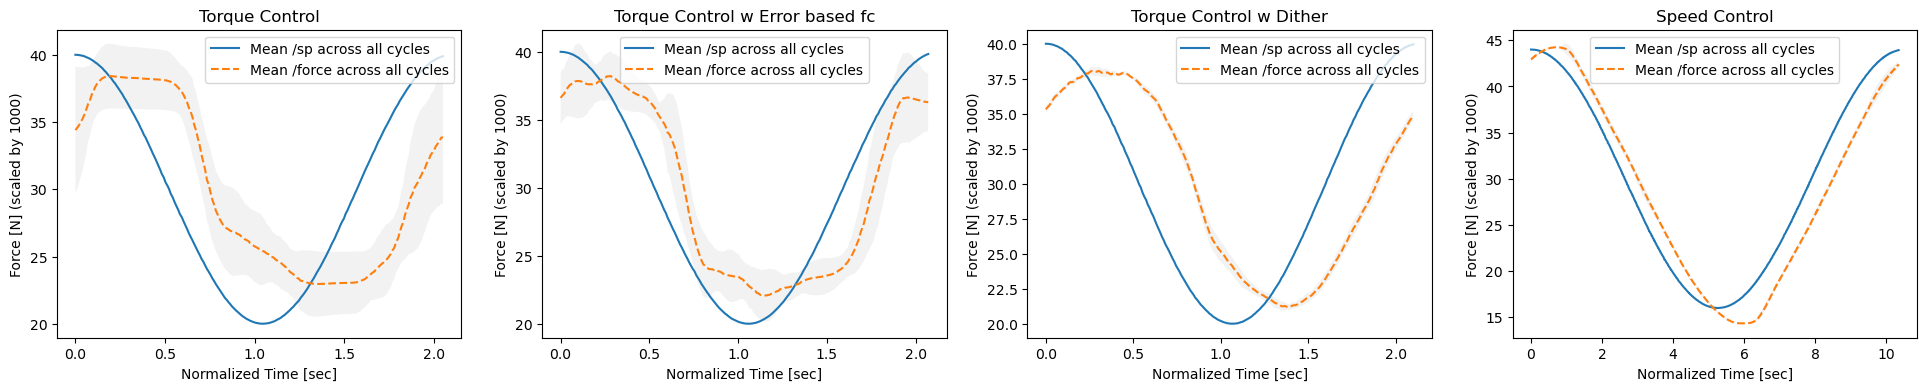

In [123]:
def plot_data(axs, idx, db_path, data, control_names):
    if data is not None:
        mean_time, mean_sp_values, mean_force_values, std_force_values = data
        ax = axs[idx]
        ax.plot(mean_time, mean_sp_values, label='Mean /sp across all cycles')
        ax.plot(mean_time, mean_force_values, label='Mean /force across all cycles', linestyle='--')
        
        # force 데이터에 대한 표준 편차 영역 추가
        ax.fill_between(mean_time, mean_force_values - std_force_values, mean_force_values + std_force_values, color='gray', alpha=0.1, edgecolor='none')

        ax.set_xlabel('Normalized Time [sec]')
        ax.set_ylabel('Force [N] (scaled by 1000)')
        ax.set_title(f'{control_names[idx]}')
        ax.legend()
    else:
        ax = axs[idx]
        ax.set_title(f'Insufficient peaks in {db_path.split("/")[idx]} for analysis')

rows = 1
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))

for idx, db_path in enumerate(db_paths):
    data = process_data(db_path)
    plot_data(axs.ravel(), idx, db_path, data, control_names)

plt.show()


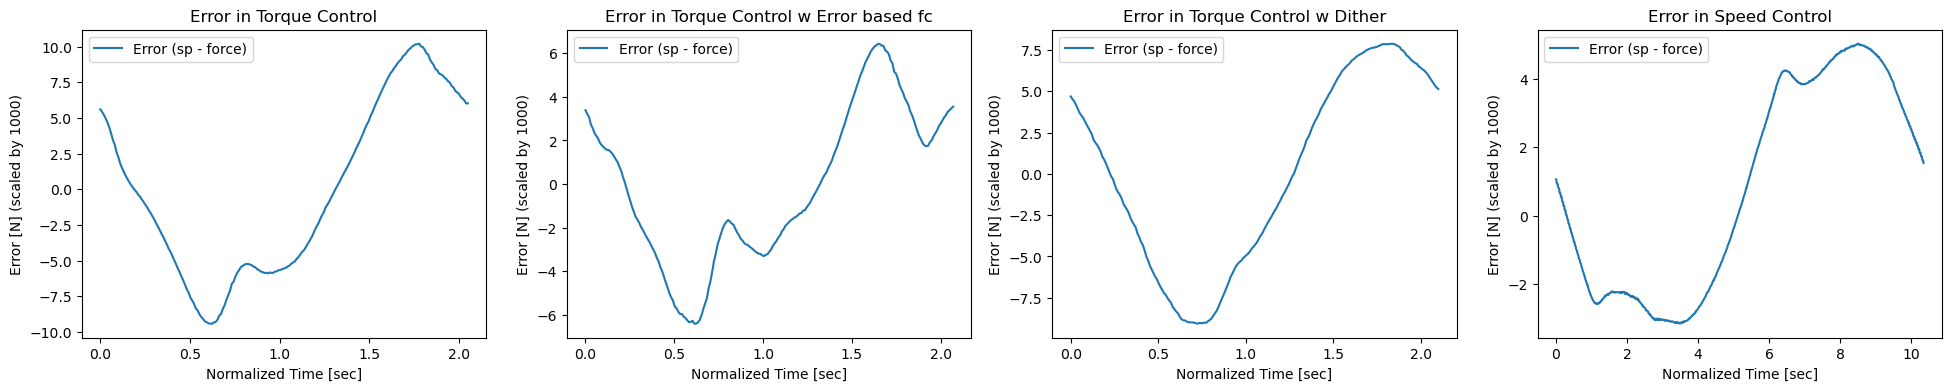

In [127]:
def plot_error(axs, idx, db_path, data, control_names):
    if data is not None:
        mean_time, mean_sp_values, mean_force_values, _ = data
        
        # 에러 계산
        error = mean_sp_values - mean_force_values
        
        ax = axs[idx]
        ax.plot(mean_time, error, label='Error (sp - force)')
        ax.set_xlabel('Normalized Time [sec]')
        ax.set_ylabel('Error [N] (scaled by 1000)')
        ax.set_title(f'Error in {control_names[idx]}')
        ax.legend()
    else:
        ax = axs[idx]
        ax.set_title(f'Insufficient peaks in {db_path.split("/")[-1]} for analysis')


fig, axs = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))

for idx, db_path in enumerate(db_paths):
    data = process_data(db_path)
    plot_error(axs.ravel(), idx, db_path, data, control_names)

plt.show()
